# Example 10: Cell Death Index (CDI)

In this notebook, we use two different normalized fluorescent intensity channels to calculate the non-binary cell death index as a measure of viability for individual cells. A simple mathematical formulation to determine cell death using two fluorescent channels can be defined by the cross ratio between high viability and low viability signals. Consider the following case:

1. **Channel 1 (C1)**: High fluorescence → High viability (e.g., live cell marker like green fluorescent protein (GFP) or cell tracker far red (CTFR)).
2. **Channel 2 (C2)**: High fluorescence → Low viability (e.g., dead cell marker like propidium iodide (PI)).

With the formula:
$$\text{Cell Death Index (CDI)}=\frac{C2_{norm}}{C1_{norm} + C2_{norm}}$$

where $_{norm}$ refers to the normalized intensity.

## Headers

In [2]:
import os
import dask
import dask.dataframe as dd
import dask_image.imread
import dask.array as da
from dask.distributed import LocalCluster
from dask.distributed import Client
import matplotlib.pyplot as plt
from nested_dict import nested_dict
import pandas as pd
import numpy as np
from tqdm import tqdm
import itertools
from aicsimageio import AICSImage
import seaborn as sns
from scipy.stats import gaussian_kde
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
from matplotlib import cm
from matplotlib.colors import ListedColormap, Normalize, LogNorm, BoundaryNorm
import matplotlib.colors as mcolors

from cyto.postprocessing.sparse_to_sparse import *

## Configuration

In [3]:
pd.set_option('display.max_columns', None)

### Dask Setup

In [4]:
client = Client()
client

/home/vpfannenstill/mambaforge/envs/cyto/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36875 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:36875/status,
Dashboard: http://127.0.0.1:36875/status,Workers: 8
Total threads: 32,Total memory: 251.55 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36807,Workers: 8
Dashboard: http://127.0.0.1:36875/status,Total threads: 32
Started: Just now,Total memory: 251.55 GiB
Comm: tcp://127.0.0.1:46639,Total threads: 4
Dashboard: http://127.0.0.1:46113/status,Memory: 31.44 GiB
Nanny: tcp://127.0.0.1:37455,


## Data Loading

### Load Cyto Tcell Dask Dataframe

In [5]:
path_track_tcell_merge_ddf = "/mnt/Data/UTSE/2023_11_24_1G4PrimCD8_Nyeso1_HCT116_CTFR_100nM_ICAM5ug_framerate10sec_flow_0p1mlperh_analysis/plots/contact_analysis/Cyto/Tcell/track_tcell_merge_int_contact_ddf.csv"
track_tcell_merge_ddf = dd.read_csv(path_track_tcell_merge_ddf)

### Load Cyto Cancer Cell Dask Dataframe

In [6]:
path_track_cancer_merge_ddf = "/mnt/Data/UTSE/2023_11_24_1G4PrimCD8_Nyeso1_HCT116_CTFR_100nM_ICAM5ug_framerate10sec_flow_0p1mlperh_analysis/plots/contact_analysis/Cyto/Cancer/track_cancer_merge_int_contact_ddf.csv"
track_cancer_merge_ddf = dd.read_csv(path_track_cancer_merge_ddf)

### Quantile Normalization of Both Dask Dataframes

In [7]:
percentile = 5

track_tcell_merge_ddf, ctfr_lp, ctfr_up = intensity_norm_percentile(track_tcell_merge_ddf,channel="ctfr_mean", percentile=percentile)
track_tcell_merge_ddf, pi_lp, pi_up = intensity_norm_percentile(track_tcell_merge_ddf,channel="pi_mean", percentile=percentile)

track_tcell_merge_ddf = intensity_norm(track_tcell_merge_ddf,channel="ctfr_sd", lower=ctfr_lp, upper=ctfr_up)
track_tcell_merge_ddf = intensity_norm(track_tcell_merge_ddf,channel="pi_sd", lower=pi_lp, upper=pi_up)

track_cancer_merge_ddf, gfp_lp, gfp_up = intensity_norm_percentile(track_cancer_merge_ddf,channel="gfp_mean", percentile=percentile)
track_cancer_merge_ddf, pi_lp, pi_up = intensity_norm_percentile(track_cancer_merge_ddf,channel="pi_mean", percentile=percentile)

track_cancer_merge_ddf = intensity_norm(track_cancer_merge_ddf,channel="gfp_sd", lower=gfp_lp, upper=gfp_up)
track_cancer_merge_ddf = intensity_norm(track_cancer_merge_ddf,channel="pi_sd", lower=pi_lp, upper=pi_up)
track_cancer_merge_ddf

,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,bbox_istart,bbox_jstart,bbox_isize,bbox_jsize,size,elongation,flatness,roundness,feret_diameter,feret_radius,perimeter,mass,pi_mean,pi_median,pi_sd,frame,channel,alive,track_id,id,dist_from_ultrack,tracked frames,tracked length,mean tracked cell size,gfp_mean,gfp_median,gfp_sd,closest cell dist,contact,contacting cell labels,gfp_mean_norm,pi_mean_norm,gfp_sd_norm,pi_sd_norm
npartitions=180,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,string,float64,int64,int64,float64,int64,int64,float64,float64,float64,float64,float64,bool,string,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


### T Cell CDI Compute

In [8]:
track_tcell_merge_ddf = calculate_cdi(track_tcell_merge_ddf, 'ctfr_mean_norm', 'pi_mean_norm')

# compute only for analysis relevant columns
track_tcell_cdi = track_tcell_merge_ddf[["frame","track_id", "tracked length", "contact", "ctfr_mean_norm", "ctfr_sd_norm", "pi_mean_norm", "pi_sd_norm", "CDI"]].compute()
track_tcell_cdi = track_tcell_cdi.sort_values(by=["track_id","frame"])
track_tcell_cdi['accumulated_contacts'] = track_tcell_cdi.groupby('track_id')['contact'].cumsum()
track_tcell_cdi

,frame,track_id,tracked length,contact,ctfr_mean_norm,ctfr_sd_norm,pi_mean_norm,pi_sd_norm,CDI,accumulated_contacts
27759,39,1,21,True,0.028290,0.0,0.160709,0.000000,0.850319,1
27760,39,1,21,True,0.028290,0.0,0.160709,0.000000,0.850319,2
118637,40,1,21,True,0.022515,0.0,0.242161,0.000000,0.914934,3
118638,40,1,21,True,0.022515,0.0,0.242161,0.000000,0.914934,4
11796,42,1,21,True,0.029225,0.0,0.136999,0.000000,0.824185,5
...,...,...,...,...,...,...,...,...,...,...
13249,8473,283565,181,True,0.038221,0.0,0.811712,0.239282,0.955030,48
25087,8474,283565,181,True,0.042026,0.0,0.798051,0.246170,0.949974,49
131383,8475,283565,181,True,0.043413,0.0,0.813097,0.257336,0.949314,50
5237,8476,283565,181,True,0.043362,0.0,0.783845,0.244869,0.947581,51


### Cancer Cell CDI Compute

In [9]:
track_cancer_merge_ddf = calculate_cdi(track_cancer_merge_ddf, 'gfp_mean_norm', 'pi_mean_norm')

# compute only for analysis relevant columns
track_cancer_cdi = track_cancer_merge_ddf[["frame","track_id", "tracked length", "contact", "gfp_mean_norm", "gfp_sd_norm", "pi_mean_norm", "pi_sd_norm", "CDI"]].compute()
track_cancer_cdi = track_cancer_cdi.sort_values(by=["track_id","frame"])
track_cancer_cdi['accumulated_contacts'] = track_cancer_cdi.groupby('track_id')['contact'].cumsum()
track_cancer_cdi

,frame,track_id,tracked length,contact,gfp_mean_norm,gfp_sd_norm,pi_mean_norm,pi_sd_norm,CDI,accumulated_contacts
103594,20,1,180,True,0.271312,0.138235,0.0,0.000000,0.0,1
132740,21,1,180,True,0.289624,0.143576,0.0,0.000000,0.0,2
101042,22,1,180,True,0.283493,0.141589,0.0,0.000000,0.0,3
102179,31,1,180,True,0.390882,0.140123,0.0,0.000000,0.0,4
116825,37,1,180,True,0.288199,0.115938,0.0,0.000000,0.0,5
...,...,...,...,...,...,...,...,...,...,...
114260,8460,208532,56,True,1.000000,1.000000,1.0,0.719457,0.5,39
50577,8461,208532,56,True,1.000000,1.000000,1.0,0.736291,0.5,40
145345,8462,208532,56,True,1.000000,1.000000,1.0,0.810483,0.5,41
145945,8463,208532,56,True,1.000000,1.000000,1.0,0.823194,0.5,42


### Explore the Normalization Behaviour - Plot Interquartile Range (IQR) - CDI strongly depends on it

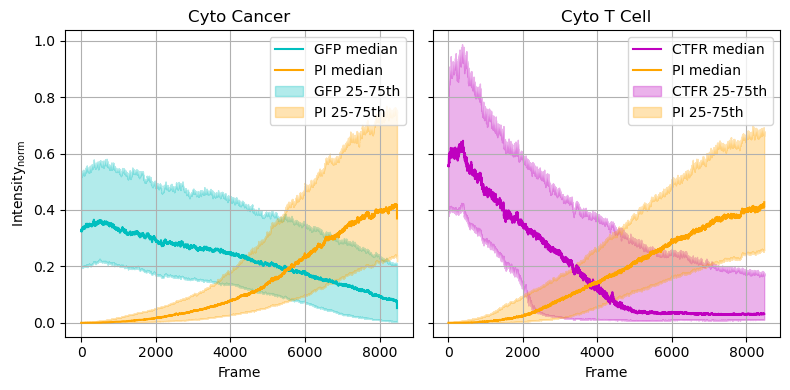

In [14]:
fig, axs = plt.subplots(1,2, figsize=(8, 4), sharey=True)

# cancer
sns.lineplot(track_cancer_cdi.groupby('frame')['gfp_mean_norm'].median(), color='c', label="GFP median", ax=axs[0])
sns.lineplot(track_cancer_cdi.groupby('frame')['pi_mean_norm'].median(), color='orange', label="PI median", ax=axs[0])

# Calculate the IQR for GFP
q1_gfp = track_cancer_cdi.groupby('frame')['gfp_mean_norm'].quantile(0.25)
q3_gfp = track_cancer_cdi.groupby('frame')['gfp_mean_norm'].quantile(0.75)
axs[0].fill_between(q1_gfp.index, q1_gfp, q3_gfp, color="c", alpha=0.3, label="GFP 25-75th")

# Calculate the IQR for PI
q1_pi = track_cancer_cdi.groupby('frame')['pi_mean_norm'].quantile(0.25)
q3_pi = track_cancer_cdi.groupby('frame')['pi_mean_norm'].quantile(0.75)
axs[0].fill_between(q1_pi.index, q1_pi, q3_pi, color="orange", alpha=0.3, label="PI 25-75th")

axs[0].set_xlabel('Frame')
axs[0].set_ylabel(r'$\text{Intensity}_{\text{norm}}$')
axs[0].grid(True)
axs[0].legend()
axs[0].set_title("Cyto Cancer")

# tcell
sns.lineplot(track_tcell_cdi.groupby('frame')['ctfr_mean_norm'].median(), color='m', label="CTFR median", ax=axs[1])
sns.lineplot(track_tcell_cdi.groupby('frame')['pi_mean_norm'].median(), color='orange', label="PI median", ax=axs[1])

# Calculate the IQR for CTFR
q1_ctfr = track_tcell_cdi.groupby('frame')['ctfr_mean_norm'].quantile(0.25)
q3_ctfr = track_tcell_cdi.groupby('frame')['ctfr_mean_norm'].quantile(0.75)
axs[1].fill_between(q1_ctfr.index, q1_ctfr, q3_ctfr, color="m", alpha=0.3, label="CTFR 25-75th")

# Calculate the IQR for PI
q1_pi_tcell = track_tcell_cdi.groupby('frame')['pi_mean_norm'].quantile(0.25)
q3_pi_tcell = track_tcell_cdi.groupby('frame')['pi_mean_norm'].quantile(0.75)
axs[1].fill_between(q1_pi_tcell.index, q1_pi_tcell, q3_pi_tcell, color="orange", alpha=0.3, label="PI 25-75th")

axs[1].set_xlabel('Frame')
axs[1].grid(True)
axs[1].legend()
axs[1].set_title("Cyto T Cell")

plt.tight_layout()


### Plot the Mean and Median CDI for Both Cell Types, explore their IQR as well as their distributions

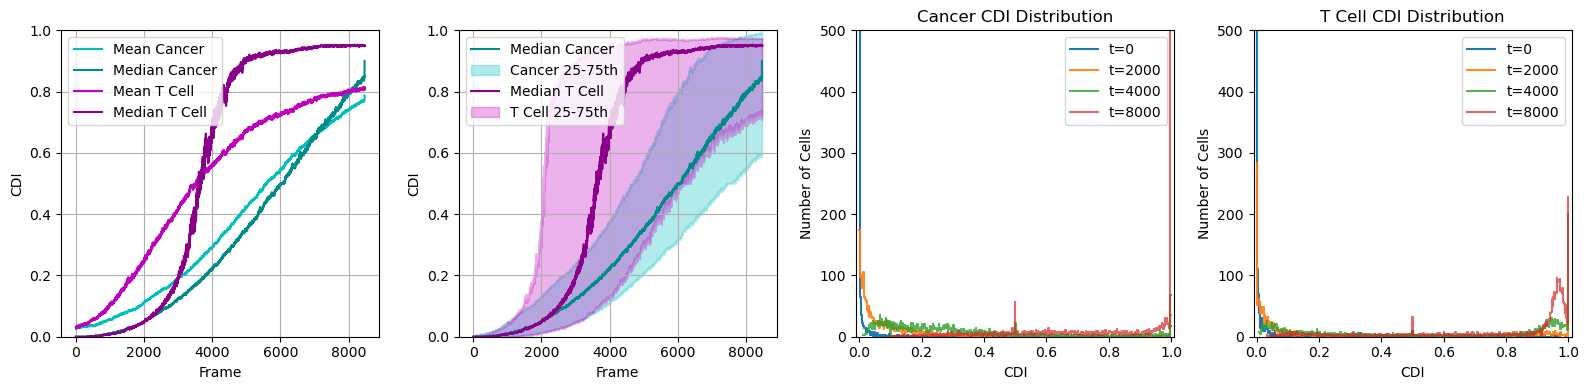

In [29]:
timepoints = [0, 2000, 4000, 8000]  #in frames


fig, axs = plt.subplots(1,4, figsize=(16, 4))

# mean and median CDI for both cell types 
sns.lineplot(track_cancer_cdi.groupby('frame')['CDI'].mean(), color='c', label="Mean Cancer", ax=axs[0])
sns.lineplot(track_cancer_cdi.groupby('frame')['CDI'].median(), color='darkcyan', label="Median Cancer", ax=axs[0])

sns.lineplot(track_tcell_cdi.groupby('frame')['CDI'].mean(), color='m', label="Mean T Cell", ax=axs[0])
sns.lineplot(track_tcell_cdi.groupby('frame')['CDI'].median(), color='darkmagenta', label="Median T Cell", ax=axs[0])

axs[0].set_xlabel('Frame')
axs[0].set_ylim(0,1)
axs[0].set_ylabel('CDI')
axs[0].grid(True)

#IQR
sns.lineplot(track_cancer_cdi.groupby('frame')['CDI'].median(), color='darkcyan', label="Median Cancer", ax=axs[1])
q1_cc = track_cancer_cdi.groupby('frame')['CDI'].quantile(0.25)
q3_cc = track_cancer_cdi.groupby('frame')['CDI'].quantile(0.75)
axs[1].fill_between(q1_cc.index, q1_cc, q3_cc, color="c", alpha=0.3, label="Cancer 25-75th")

sns.lineplot(track_tcell_cdi.groupby('frame')['CDI'].median(), color='darkmagenta', label="Median T Cell", ax=axs[1])
q1_tcell = track_tcell_cdi.groupby('frame')['CDI'].quantile(0.25)
q3_tcell = track_tcell_cdi.groupby('frame')['CDI'].quantile(0.75)
axs[1].fill_between(q1_tcell.index, q1_tcell, q3_tcell, color="m", alpha=0.3, label="T Cell 25-75th")

axs[1].set_xlabel('Frame')
axs[1].set_ylim(0,1)
axs[1].set_ylabel('CDI')
axs[1].grid(True)

#cancer CDI histograms
sns.histplot(track_cancer_cdi[track_cancer_cdi["frame"]==timepoints[0]]['CDI'], stat="count", binwidth=0.002,element="step", fill=False, label="t={}".format(timepoints[0]), ax=axs[2])
sns.histplot(track_cancer_cdi[track_cancer_cdi["frame"]==timepoints[1]]['CDI'],stat="count", binwidth=0.002, element="step", alpha=0.9,fill=False, label="t={}".format(timepoints[1]), ax=axs[2])
sns.histplot(track_cancer_cdi[track_cancer_cdi["frame"]==timepoints[2]]['CDI'],stat="count", binwidth=0.002,element="step",alpha=0.8, fill=False,label="t={}".format(timepoints[2]), ax=axs[2])
sns.histplot(track_cancer_cdi[track_cancer_cdi["frame"]==timepoints[3]]['CDI'],stat="count", binwidth=0.002,element="step",alpha=0.7,fill=False, label="t={}".format(timepoints[3]), ax=axs[2])

axs[2].set_xlim(-0.01,1.01)
axs[2].set_ylim(0,500)
axs[2].set_xlabel('CDI')
axs[2].set_ylabel('Number of Cells')
axs[2].set_title("Cancer CDI Distribution")

#tcell CDI histograms
sns.histplot(track_tcell_cdi[track_tcell_cdi["frame"]==timepoints[0]]['CDI'], stat="count", binwidth=0.002,element="step", fill=False, label="t={}".format(timepoints[0]), ax=axs[3])
sns.histplot(track_tcell_cdi[track_tcell_cdi["frame"]==timepoints[1]]['CDI'],stat="count", binwidth=0.002, element="step", alpha=0.9,fill=False, label="t={}".format(timepoints[1]), ax=axs[3])
sns.histplot(track_tcell_cdi[track_tcell_cdi["frame"]==timepoints[2]]['CDI'],stat="count", binwidth=0.002,element="step",alpha=0.8, fill=False,label="t={}".format(timepoints[2]), ax=axs[3])
sns.histplot(track_tcell_cdi[track_tcell_cdi["frame"]==timepoints[3]]['CDI'],stat="count", binwidth=0.002,element="step",alpha=0.7,fill=False, label="t={}".format(timepoints[3]), ax=axs[3])

axs[3].set_xlim(-0.01,1.01)
axs[3].set_ylim(0,500)
axs[3].set_xlabel('CDI')
axs[3].set_ylabel('Number of Cells')
axs[3].set_title("T Cell CDI Distribution")


for ax in axs:
    ax.legend()

plt.tight_layout()

## Explore Relationship between CDI and Contacts 

### First plot contacts over time

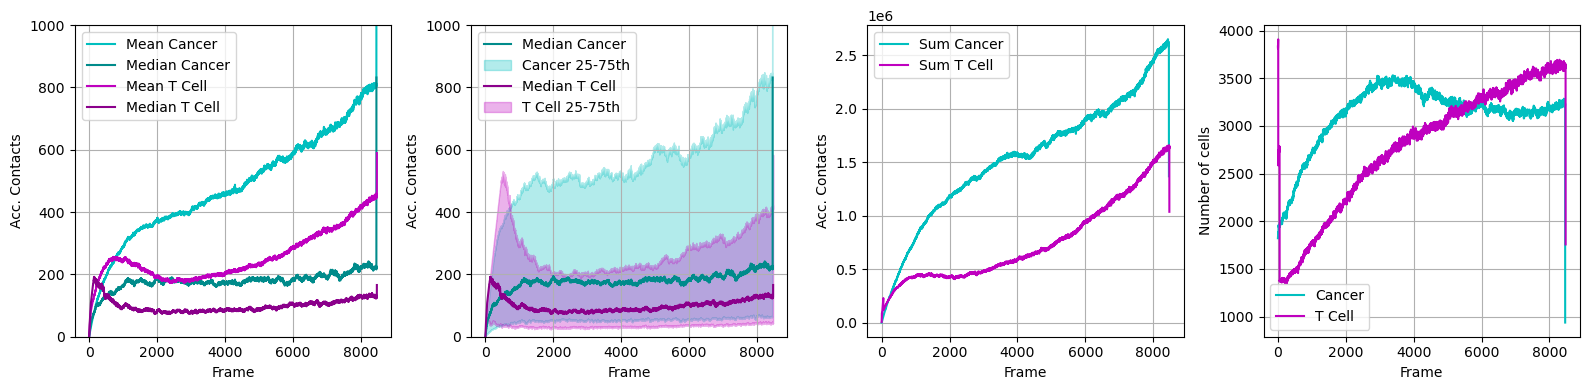

In [27]:
fig, axs = plt.subplots(1,4, figsize=(16, 4))

# mean and median number of accumulated contacts for both cell types
sns.lineplot(track_cancer_cdi.groupby('frame')['accumulated_contacts'].mean(), color='c', label="Mean Cancer", ax=axs[0])
sns.lineplot(track_cancer_cdi.groupby('frame')['accumulated_contacts'].median(), color='darkcyan', label="Median Cancer", ax=axs[0])
sns.lineplot(track_tcell_cdi.groupby('frame')['accumulated_contacts'].mean(), color='m', label="Mean T Cell", ax=axs[0])
sns.lineplot(track_tcell_cdi.groupby('frame')['accumulated_contacts'].median(), color='darkmagenta', label="Median T Cell", ax=axs[0])

axs[0].set_xlabel('Frame')
axs[0].set_ylabel('Acc. Contacts')
axs[0].set_ylim(0,1000)
axs[0].grid(True)

#IQR
sns.lineplot(track_cancer_cdi.groupby('frame')['accumulated_contacts'].median(), color='darkcyan', label="Median Cancer", ax=axs[1])
q1_cc = track_cancer_cdi.groupby('frame')['accumulated_contacts'].quantile(0.25)
q3_cc = track_cancer_cdi.groupby('frame')['accumulated_contacts'].quantile(0.75)
axs[1].fill_between(q1_cc.index, q1_cc, q3_cc, color="c", alpha=0.3, label="Cancer 25-75th")

sns.lineplot(track_tcell_cdi.groupby('frame')['accumulated_contacts'].median(), color='darkmagenta', label="Median T Cell", ax=axs[1])
q1_tcell = track_tcell_cdi.groupby('frame')['accumulated_contacts'].quantile(0.25)
q3_tcell = track_tcell_cdi.groupby('frame')['accumulated_contacts'].quantile(0.75)
axs[1].fill_between(q1_tcell.index, q1_tcell, q3_tcell, color="m", alpha=0.3, label="T Cell 25-75th")

axs[1].set_xlabel('Frame')
axs[1].set_ylabel('Acc. Contacts')
axs[1].set_ylim(0,1000)
axs[1].grid(True)

# total sum of acc. contacts over time
sns.lineplot(track_cancer_cdi.groupby('frame')['accumulated_contacts'].sum(), color='c', label="Sum Cancer", ax=axs[2])
sns.lineplot(track_tcell_cdi.groupby('frame')['accumulated_contacts'].sum(), color='m', label="Sum T Cell", ax=axs[2])

axs[2].set_xlabel('Frame')
axs[2].set_ylabel('Acc. Contacts')
axs[2].grid(True)

#check total number of cells that have contacts
sns.lineplot(track_cancer_cdi.groupby('frame')['accumulated_contacts'].count(), color='c', label="Cancer", ax=axs[3])
sns.lineplot(track_tcell_cdi.groupby('frame')['accumulated_contacts'].count(), color='m', label="T Cell", ax=axs[3])

axs[3].set_xlabel('Frame')
axs[3].set_ylabel('Number of cells')
axs[3].grid(True)

for ax in axs:
    ax.legend()

plt.tight_layout()

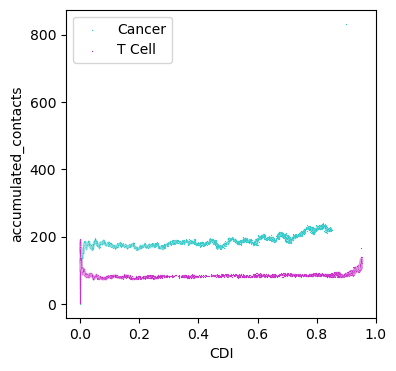

In [33]:
fig, axs = plt.subplots(1,1, figsize=(4, 4))

sns.scatterplot(x=track_cancer_cdi.groupby('frame')['CDI'].median(),
                y=track_cancer_cdi.groupby('frame')['accumulated_contacts'].median(),
                color='c', s=0.7, label="Cancer", ax=axs)
sns.scatterplot(x=track_tcell_cdi.groupby('frame')['CDI'].median(),
                y=track_tcell_cdi.groupby('frame')['accumulated_contacts'].median(),
                color='m', s=0.7, label="T Cell", ax=axs)
plt.show()

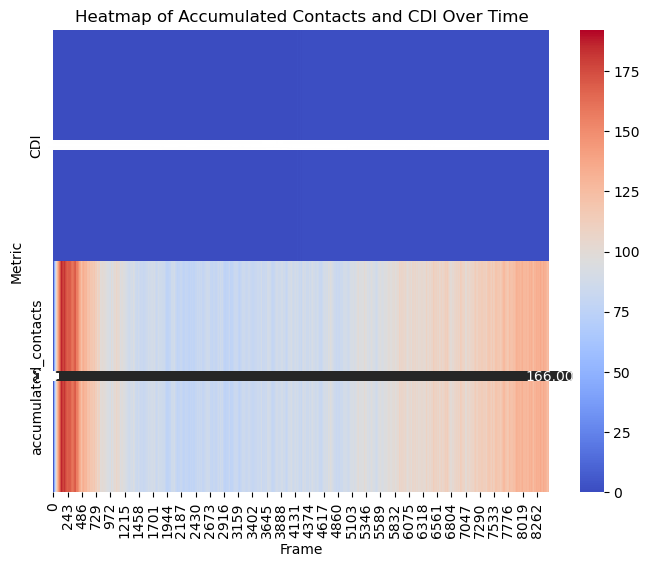

In [64]:
plt.figure(figsize=(8, 6))
heatmap_data = track_tcell_cdi.pivot_table(index='frame', values=['accumulated_contacts', 'CDI'], aggfunc='median')
sns.heatmap(heatmap_data.T, cmap='coolwarm', annot=True, fmt=".2f")

plt.xlabel('Frame')
plt.ylabel('Metric')
plt.title('Heatmap of Accumulated Contacts and CDI Over Time')
plt.show()